# Verarbeitung und Darstellung der Messdaten


## Import all libraries and load data as pandas dataframe


In [1]:
#import libraries
import pandas as pd
import numpy as np
import scipy.signal as sci
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

# Datei einlesen (achte auf den richtigen Pfad)
df = pd.read_csv("Daten/Lab1_10s-1Achse.txt", sep="\t", decimal=",", encoding="utf-8")  # oder sep=";" / sep="\s+"
df.to_csv("Daten/Lab1_10s-1Achse.csv", index=False, sep=";") # als Semikolon-CSV speichern
df2 = pd.read_csv("Daten/Lab1_10s-1Achse.csv", sep=";") # CSV-Datei einlesen
df2.columns = ["x", "y", "z", "time_ms"]
# Zeit in Sekunden umrechnen
df2["time_s"] = df2["time_ms"] / 1000.0


<Axes: title={'center': 'Accelerometer Test'}, xlabel='Time in s', ylabel='Acceleration in g'>

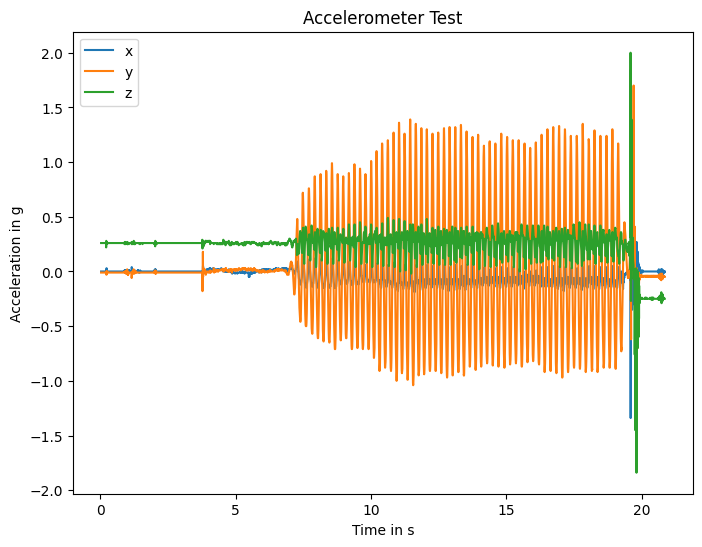

In [3]:
# display data
df2.plot(x = 'time_s', y = ['x', 'y', 'z'], ylabel='Acceleration in g', 
        xlabel='Time in s', figsize= [8, 6], title="Accelerometer Test")


<Axes: title={'center': 'Filtered Accelerometer Test'}, xlabel='Time in s', ylabel='Acceleration in g'>

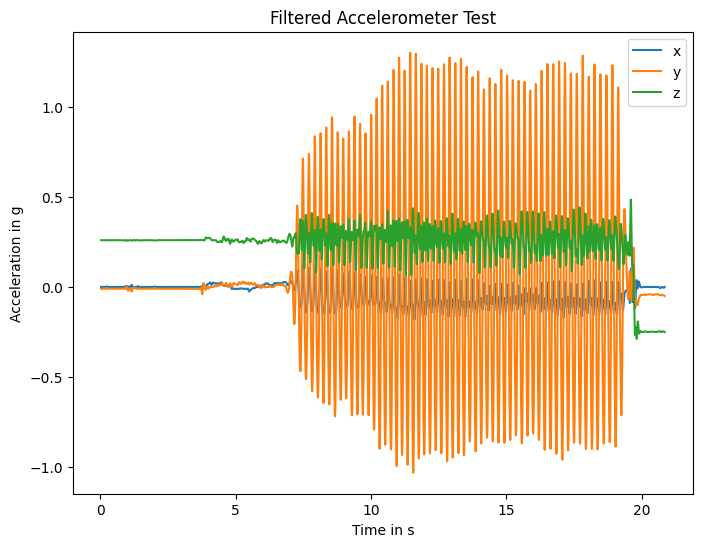

In [4]:
# Butterworth Filter
df_filtered = df2.copy()
b, a = sci.butter(4, 0.1)
df_filtered['x'] = sci.filtfilt(b, a, df2['x'])
df_filtered['y'] = sci.filtfilt(b, a, df2['y'])
df_filtered['z'] = sci.filtfilt(b, a, df2['z']) 


# display filtered data
df_filtered.plot(x = 'time_s', y = ['x', 'y', 'z'], ylabel='Acceleration in g', 
        xlabel='Time in s', figsize= [8, 6], title="Filtered Accelerometer Test")

# Filter acceleration data applying different filter techniques
## Bandpass filter (Butterworth 4. order)

Wir möchten einen Filter verwende, der das Signal nicht verschiebt, demnach einen zero-Phase Filter. Scipy bietet diese Option mit der _filtfilt()_ Methode an. Dieser verwendet zwei _Infinite Impuls Response_ Filter hintereinander geschaltet, jedoch wird der erste vorwärts und der zweite rückwärts angewandt, um keine Phasenverschiebung zu erhalten.

Dies ist auch in folgender Abbildung zu erkennen. Die gestrichelte rote Line stellt einen Filter dar, welcher das Signal filtert und störende Frequenzen entfernt, jedoch ist dieser um eine Phase verschoben zum eigentlichen Signal. Die rote Line ist die zweite Anwendung des Filters. Würde man den zweiten Filter jedoch rückwärts anwenden, würde man die schwarze Linie und somit das Ergebnis der _filtfilt()_ methode erhalten.



![Unterschied zwischen verschiedenen Filtertypen](bilder/zeroPhase.png)

In [5]:
# Setting up a butterworth filter 

def butter_bandpass(lowcut,fs,order=4):
    
    # nyq: Nyquist Theorem
    nyq = 0.5 * fs
    # low is calculated in relation to cutoff frequency and sampling frequency
    low = lowcut / nyq
    
    #order = 4
    
    b, a = sci.butter(order, [low], 'lowpass', analog=False)
    
    return b, a

In [6]:
def butter_bandpass_filter(signal, lowcut, fs, order):
    #use filtfilt for a zero-phase filtering
    b, a = butter_bandpass(lowcut,fs, order)
    y = sci.filtfilt(b, a, signal, axis = 0)
    return y

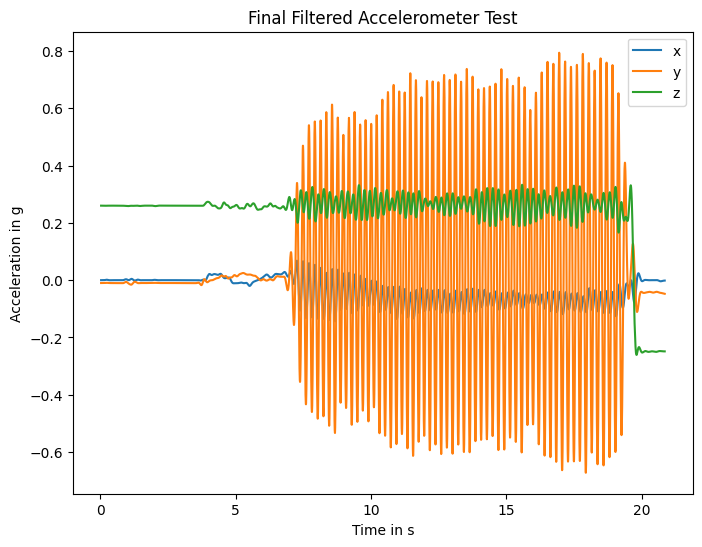

In [7]:
# Filter the data
fs = 800  # Sampling frequency
lowcut = 16.0  # Desired cutoff frequency of the filter, Hz
df_final = df2.copy()
df_final = butter_bandpass_filter(df2[['x', 'y', 'z']], lowcut, fs, order=4)
# convert back to DataFrame
df_final = pd.DataFrame(df_final, columns=['x', 'y', 'z'])
df_final['time_s'] = df2['time_s']
# display final filtered data
df_final.plot(x = 'time_s', y = ['x', 'y', 'z'], ylabel='Acceleration in g', 
        xlabel='Time in s', figsize= [8, 6], title="Final Filtered Accelerometer Test")
plt.show()